In [ ]:
!pip install scikeras

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error,r2_score, make_scorer
import pdb
import sys

## for Deep-learing:
import tensorflow as tf
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
import itertools
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Activation
from scikeras.wrappers import KerasRegressor
import time

# Constants

In [ ]:
# number of hours per day
HOURS_PER_DAY = 24

# number of days per year
DAYS_PER_YEAR = 365

# start year of data
START_YEAR = 2018

# end year of data
END_YEAR = 2021

# a constant to add for stability
EPSILON = 0.1

# Functions

---

## Loss and Model Fit Functions

The loss function that we'll use in the project is the NSE* loss:

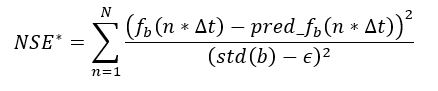

Where:

$ b $ - Basin number - b.

$ \Delta t $ - Time resolution.

$ N $ - Number of sequences.

$ f_b(n*\Delta t) $ - The true flow rate at time $ n*\Delta t $

$ pred\_f_b(n*\Delta t) $ - The predicted flow rate at time $ n*\Delta t $

$ std(b) $ - The standart deviation of the true flows in basin b.



In [ ]:
# NSE* loss function
def get_nse_loss(std):

  std = tf.constant(std, dtype=tf.float32)

  def nse_star(y_true, y_pred):
      loss = tf.reduce_sum(tf.divide(tf.square(tf.subtract(y_true, y_pred)), tf.square(tf.add(std, EPSILON))))
      return loss

  return nse_star

The first metric we'll use to evaluate the model is the NSE metric:

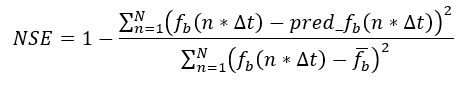

Where $ \bar {f_b} $ is the mean of true flows for basin b, and the rest of the parameters are as explained above.

In [ ]:
# NSE score metric - numpy version
def get_nse_numpy(mean):

  def nse_numpy(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred)**2) / (np.sum((mean - y_true)**2) + EPSILON)

  return nse_numpy

In [ ]:
# NSE score metric - tensor version
def get_nse_tensor(mean):

  def nse_tensor(y_true, y_pred):
    return 1 - tf.divide(tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred))), (tf.reduce_sum(tf.square(tf.subtract(y_true, mean))) + EPSILON))

  return nse_tensor

The second metric we'll use is the persistNSE metric:

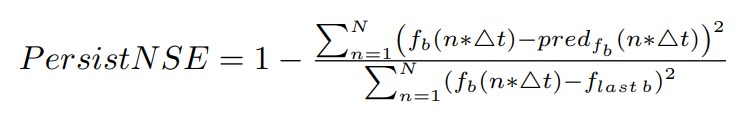

Where $ f_{lastb} $ is the last observation for station b, and the rest of the parameters are as explained above.

In [ ]:
# persistentNSE score metric - numpy version
def persistent_nse_numpy(y_true, y_pred):
    last_sample = y_true[-1]
    return 1 - np.sum((y_true - y_pred)**2) / (np.sum((last_sample - y_true)**2) + EPSILON)

In [ ]:
# persistentNSE score metric - tensor version
def persistent_nse_tensor(y_true, y_pred):
    last_sample = y_true[-1]
    return 1 - tf.divide(tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred))), (tf.reduce_sum(tf.square(tf.subtract(y_true, last_sample))) + EPSILON))

## Functions for model and training

In [ ]:
# Converts an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# Converts series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
# Normalizes data using MinMaxScaler
def normalize_data(values):
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  return scaler, scaled

In [ ]:
# Returns scaled and reframed data
def prepare_data(dataset, n_hours):
  # load dataset
  values = dataset.values

  # normalize features
  scaler, scaled = normalize_data(values)

  # frame as supervised learning
  reframed = series_to_supervised(scaled, n_hours, 1)
  return reframed, scaler

In [ ]:
# Splits data to train and test
def split_train_and_test(reframed, n_train_hours, n_hours, n_features):
  # split into train and test sets
  values = reframed.values
  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]

  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]

  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
  test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
  return train_X, train_y, test_X, test_y

In [ ]:
# Gets data of a specific gauge
def get_data_of_gauge(gauge_id, df_flow):
    df_gauge = df_flow[df_flow['gauge_id'] == gauge_id]
    return df_gauge

In [ ]:
# Resamples the data by a given time resolution
def resample_data(df_gauge, time_resolution='1H'):
    df_gauge.set_index('time', inplace=True)
    df_gauge = df_gauge[~df_gauge.index.duplicated()]

    # Resample the data with a 10-minute interval and interpolate using linear method
    df_gauge = df_gauge.resample(time_resolution).interpolate(method='linear')
    return df_gauge

In [ ]:
# Wrap function for creating the model
def build_model(train_X, loss_func, metrics, network):

  def create_model(n_neurons=128):
    # design network
    model = Sequential()
    model.add(network(n_neurons, input_shape=(train_X.shape[1], train_X.shape[2]), dropout=0.2))
    model.add(Dense(1))
    model.compile(loss=loss_func, optimizer='adam', metrics=metrics)
    return model

  return create_model

## Functions for plots

In [ ]:
def plot_history(epochs, history, gauge_name):
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='validation')
  plt.xticks(np.arange(epochs), np.arange(1, epochs+1))
  plt.title(gauge_name)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

In [ ]:
def plot_predicted_vs_observed(model, scaler, test_X, test_y, n_hours, n_features, mean, xticks, gauge_name):
  # make a prediction
  yhat = model.predict(test_X)
  test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

  # invert scaling for forecast
  inv_yhat = np.concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
  inv_yhat = scaler.inverse_transform(inv_yhat)
  inv_yhat = inv_yhat[:,0]

  # invert scaling for actual
  test_y = test_y.reshape((len(test_y), 1))
  inv_y = np.concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
  inv_y = scaler.inverse_transform(inv_y)
  inv_y = inv_y[:,0]

  # calculate NSE
  nse_numpy = get_nse_numpy(mean)
  nse_metric = nse_numpy(inv_y, inv_yhat)
  print('Test NSE: %.3f' % nse_metric)

  # calculate persistNSE
  persist_nse_metric = persistent_nse_numpy(inv_y, inv_yhat)
  print('Test PersistentNSE: %.3f' % persist_nse_metric)

  # calculate RelBias
  # rel_bias_metric = rel_bias(inv_y, inv_yhat)
  # print('Test RelBias: %.3f' % rel_bias_metric)

  # line plot of observed vs predicted
  plt.figure(figsize=(15, 10))
  plt.plot(xticks, inv_y, label='observed')
  plt.plot(xticks, inv_yhat, label='predicted')
  plt.xticks(np.arange(0, len(xticks)+1, len(xticks)//10), rotation=60)
  plt.title(gauge_name)
  plt.xlabel('time step')
  plt.ylabel('flow rate')
  plt.legend()
  plt.show()





---

